## Random Forest

sklearn random forest classifier documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

sklearn random forest regressor documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Import the data

In [2]:
data = pd.read_csv("./Churn_Modelling.csv")

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Feature and target

X = data.drop('Exited', axis=1)
y = data['Exited'].values.flatten()

# splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train.shape, X_test.shape

((7500, 10), (2500, 10))

### Encoding the variables

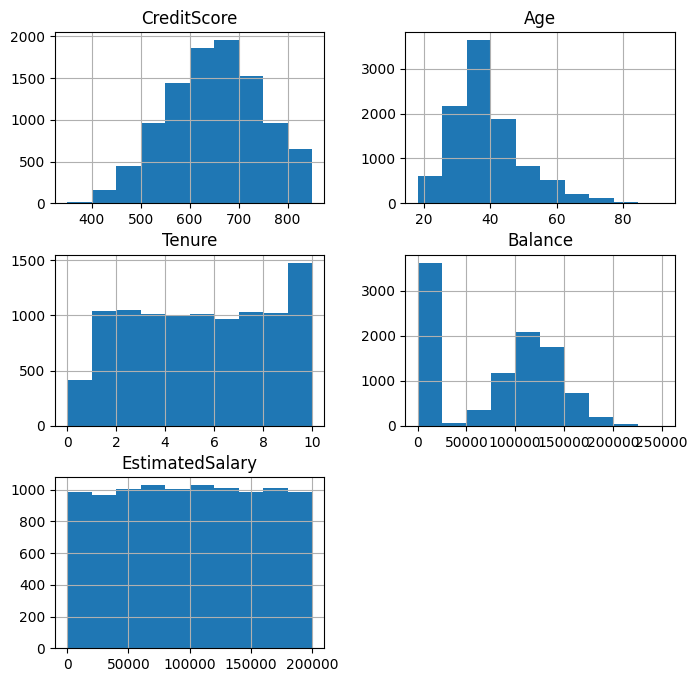

In [5]:
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_cols_non_enc = ['Geography', 'Gender']
categorical_cols_enc = ['NumOfProducts','HasCrCard', 'IsActiveMember']

X[numerical_cols].hist(figsize=(8,8));

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [7]:
preprocessor = ColumnTransformer(
                    transformers=[
                        ("standard_scaler", StandardScaler(), numerical_cols),
                        ("one_hot_encoder", OneHotEncoder(), categorical_cols_non_enc),
                        ("categorical_passthrough", "passthrough", categorical_cols_enc)
                    ]
                )

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
X_train.shape

(7500, 13)

In [9]:
preprocessor.get_feature_names_out()

array(['standard_scaler__CreditScore', 'standard_scaler__Age',
       'standard_scaler__Tenure', 'standard_scaler__Balance',
       'standard_scaler__EstimatedSalary',
       'one_hot_encoder__Geography_France',
       'one_hot_encoder__Geography_Germany',
       'one_hot_encoder__Geography_Spain',
       'one_hot_encoder__Gender_Female', 'one_hot_encoder__Gender_Male',
       'categorical_passthrough__NumOfProducts',
       'categorical_passthrough__HasCrCard',
       'categorical_passthrough__IsActiveMember'], dtype=object)

In [10]:
output_features = [x.split("__")[-1] for x in preprocessor.get_feature_names_out()]

output_features

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'EstimatedSalary',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Female',
 'Gender_Male',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

### Fitting the random forest model

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
# define the classifier
clf = RandomForestClassifier(n_estimators=200, min_samples_split=10)

# train the classifier
clf.fit(X_train, y_train)

clf

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluating on test data

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Evaluating the model on train dataset
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.8600


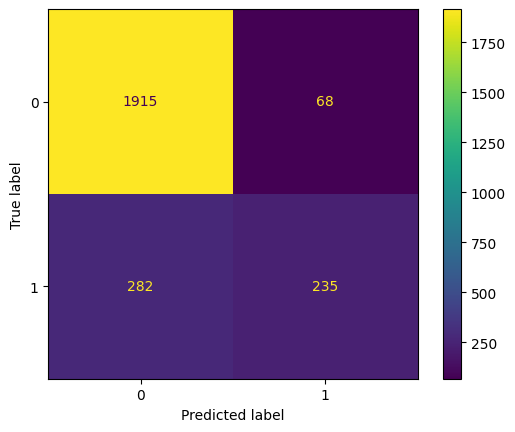

In [14]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot();

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1983
           1       0.78      0.45      0.57       517

    accuracy                           0.86      2500
   macro avg       0.82      0.71      0.74      2500
weighted avg       0.85      0.86      0.85      2500



### OOB error

In [16]:
# fit the random forest classifier with oob

clf = RandomForestClassifier(n_estimators=200, min_samples_split=10, oob_score=True)

clf.fit(X_train, y_train)

clf

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [17]:
clf.oob_score_

0.8636

In [18]:
oob_error = 1 - clf.oob_score_

oob_error

0.13639999999999997

### Feature Importance

- Random Forest improves accuracy by aggregatng multiple decision trees but **lose interpretability**. i.e. RF is not as interpretable as decision trees.

- Feature importance mitigates this problem.

#### 1. What is Feature Importance?

Feature importance tells us how much each feature (input variable) contributes to the prediction made by a model.

In the context of a Random Forest, it’s a way to rank features based on their usefulness in building decision trees that make up the forest.

#### 2. Random Forest is an ensemble of decision trees.

- Each tree is trained on a bootstrap sample (random subset) of the training data.

- At each split in a tree, a random subset of features is considered for splitting.

- The forest’s prediction is the average (for regression) or majority vote (for classification) of all trees.

Because multiple trees are built with different subsets of data and features, we can track how often and how well a feature is used to split data to measure its importance.

#### 3. Two Main Ways to Measure Feature Importance

**A. Mean Decrease in Impurity (MDI)**

1. Each time a feature is used to split a node, it reduces impurity in the dataset.

- For classification: impurity is usually Gini index or entropy.

- For regression: impurity is variance or MSE.

2. We sum the total impurity decrease brought by that feature over all trees and all nodes where it’s used.

3. The sum is normalized so that all feature importances add up to 1.

*mathematically:*

$$ Importance(f) = \sum_{t \in T} \sum_{n \in Nodes(t,f)} p(n) \cdot \Delta Impurity(n) / \text{Normalization Term}$$

Where:

- $p(n)$ = proportion of samples reaching node $n$

- $\Delta Impurity(n)$ = Impurty(parent) - weighted impurity (children)

- $ Nodes(t,f)$ = set of nodes in tree $t$ where feature $f$ was used

**pros:**

- Fast to compute (done during training)

- Built-in in sklearn’s RandomForestClassifier and RandomForestRegressor

**Cons:**

- Can be biased towards features with many categories or continuous features

- Doesn’t directly measure the predictive power on unseen data

In [19]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=10)

model.fit(X_train, y_train)

model

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
# Get feature importances
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': output_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

              Feature  Importance
1                 Age    0.276968
10      NumOfProducts    0.167497
3             Balance    0.130784
4     EstimatedSalary    0.116100
0         CreditScore    0.114713
2              Tenure    0.063113
12     IsActiveMember    0.050189
6   Geography_Germany    0.028627
11          HasCrCard    0.012726
5    Geography_France    0.010871
8       Gender_Female    0.009802
9         Gender_Male    0.009707
7     Geography_Spain    0.008902


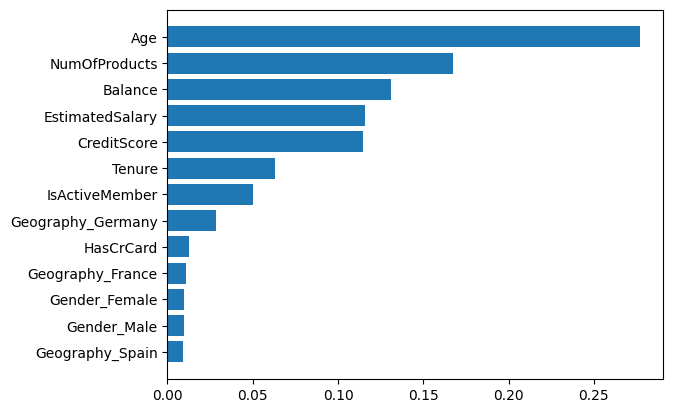

In [21]:
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.show()

**B. Mean Decrease in Accuracy (MDA) / Permutation Importance**

1. First, measure the model’s baseline accuracy (or other metric) on validation data.

2. Randomly shuffle the values of a single feature across all samples → this breaks its relationship with the target.

3. Measure the new accuracy.

4. The drop in accuracy indicates how important that feature was for prediction.

Formula:

$$ Importance(f) = Accuracy_{original} - Accuracy_{shuffled(f)} $$

**Pros:**

- Works for any model (not just tree-based)

- Measures true impact on prediction performance

**Cons:**

- Slower (requires retraining or repeated predictions)

- Can be unstable if features are correlated

In [22]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'Feature': output_features,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_df)

              Feature  Importance
1                 Age    0.116507
10      NumOfProducts    0.073560
12     IsActiveMember    0.055693
3             Balance    0.045653
6   Geography_Germany    0.032093
0         CreditScore    0.027773
4     EstimatedSalary    0.027480
2              Tenure    0.022773
5    Geography_France    0.016347
9         Gender_Male    0.015280
8       Gender_Female    0.014027
11          HasCrCard    0.010373
7     Geography_Spain    0.007000


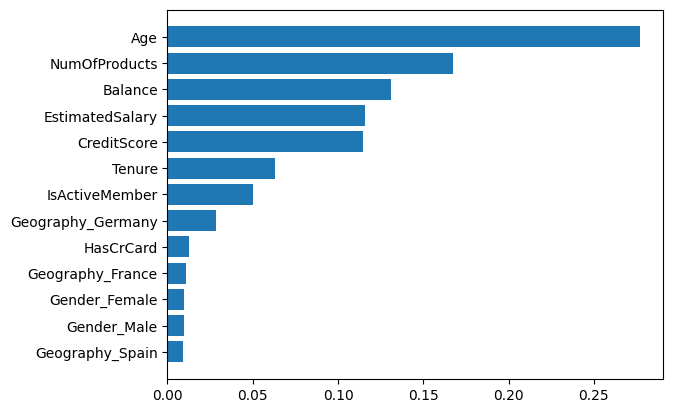

In [23]:
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.show()